In [1]:
import os
import numpy as np


In [2]:
import torchvision
import torch

import cv2

import matplotlib.pyplot as plt

## Identify the List of Human Keypoints to Track

In [3]:
human_keypoints = ['nose','left_eye','right_eye','left_ear','right_ear','left_shoulder','right_shoulder','left_elbow',
                'right_elbow','left_wrist','right_wrist','left_hip','right_hip','left_knee', 'right_knee', 'left_ankle','right_ankle']


## Identify the Possible Connections Between the Keypoints

In [4]:
def possible_keypoint_connections(keypoints):
    connections = [       
        [keypoints.index('right_eye'), keypoints.index('nose')],
        [keypoints.index('right_eye'), keypoints.index('right_ear')],
        [keypoints.index('left_eye'), keypoints.index('nose')],
        [keypoints.index('left_eye'), keypoints.index('left_ear')],
        [keypoints.index('right_shoulder'), keypoints.index('right_elbow')],
        [keypoints.index('right_elbow'), keypoints.index('right_wrist')],
        [keypoints.index('left_shoulder'), keypoints.index('left_elbow')],
        [keypoints.index('left_elbow'), keypoints.index('left_wrist')],
        [keypoints.index('right_hip'), keypoints.index('right_knee')],
        [keypoints.index('right_knee'), keypoints.index('right_ankle')],
        [keypoints.index('left_hip'), keypoints.index('left_knee')],
        [keypoints.index('left_knee'), keypoints.index('left_ankle')],
        [keypoints.index('right_shoulder'), keypoints.index('left_shoulder')],
        [keypoints.index('right_hip'), keypoints.index('left_hip')],
        [keypoints.index('right_shoulder'), keypoints.index('right_hip')],
        [keypoints.index('left_shoulder'), keypoints.index('left_hip')]
        ]
    return connections


connections = possible_keypoint_connections(human_keypoints)

## Load the Pretrained Model from the PyTorch Library

In [5]:
pretrained_model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained = True)
pretrained_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:01<00:00, 180MB/s]


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

## Input Image Preprocessing and Modeling

In [8]:
from torchvision import transforms as T

img_path = "pose.jpg"
img = cv2.imread(img_path)


transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)

output = pretrained_model([img_tensor])[0]

print(output.keys())

dict_keys(['boxes', 'labels', 'scores', 'keypoints', 'keypoints_scores'])


## Build Custom Functions to Plot the Output

In [9]:
def plot_keypoints(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    cmap = plt.get_cmap('rainbow')
    img_copy = img.copy()
    color_id = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
    for person_id in range(len(all_keypoints)):
      if confs[person_id]>conf_threshold:
        keypoints = all_keypoints[person_id, ...]
        scores = all_scores[person_id, ...]
        for kp in range(len(scores)):
            if scores[kp]>keypoint_threshold:
                keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))
                color = tuple(np.asarray(cmap(color_id[person_id])[:-1])*255)
                cv2.circle(img_copy, keypoint, 10, color, -1)

    return img_copy


In [10]:
def plot_skeleton(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    
    cmap = plt.get_cmap('rainbow')
    img_copy = img.copy()
    if len(output["keypoints"])>0:
      colors = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
      for person_id in range(len(all_keypoints)):
          if confs[person_id]>conf_threshold:
            keypoints = all_keypoints[person_id, ...]

            for conn_id in range(len(connections)):
              limb_loc1 = keypoints[connections[conn_id][0], :2].detach().numpy().astype(np.int32)
              limb_loc2 = keypoints[connections[conn_id][1], :2].detach().numpy().astype(np.int32)
              limb_score = min(all_scores[person_id, connections[conn_id][0]], all_scores[person_id, connections[conn_id][1]])
              if limb_score> keypoint_threshold:
                color = tuple(np.asarray(cmap(colors[person_id])[:-1])*255)
                cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 15)

    return img_copy

## Plot the Output on the Input Image

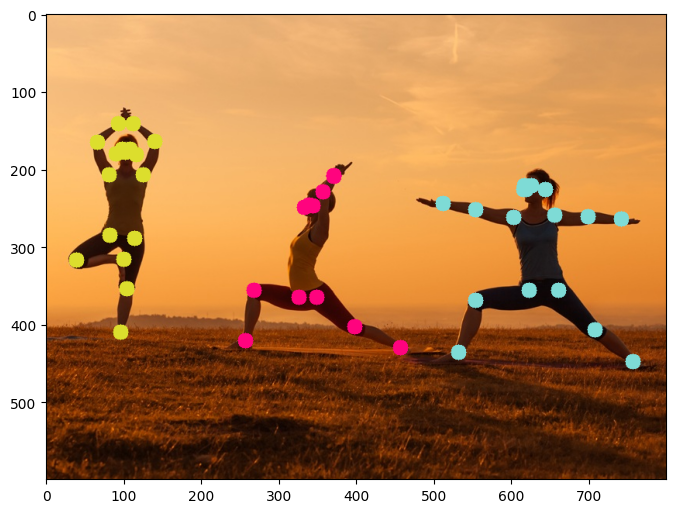

In [12]:
keypoints_img = plot_keypoints(img, output["keypoints"],output["keypoints_scores"], output["scores"],keypoint_threshold=2)
cv2.imwrite("output/keypoints-img.jpg", keypoints_img)
plt.figure(figsize=(8, 8))
plt.imshow(keypoints_img[:, :, ::-1])
plt.show()

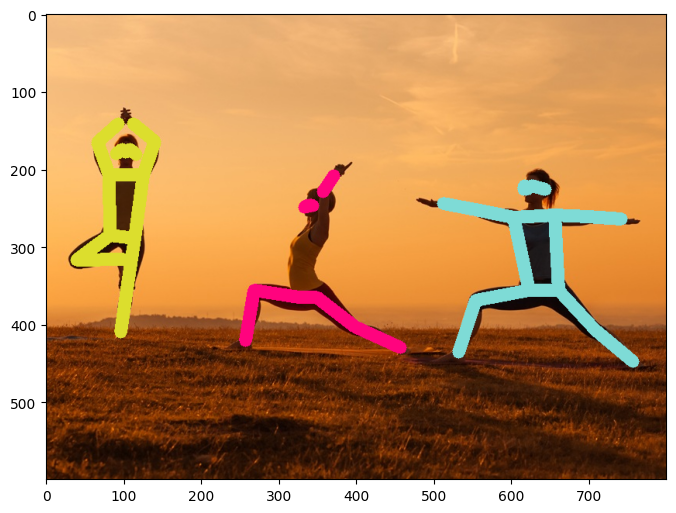

In [13]:
skeleton_img = plot_skeleton(img, output["keypoints"],output["keypoints_scores"], output["scores"],keypoint_threshold=2)
cv2.imwrite("output/skeleton-img.jpg", skeleton_img)
plt.figure(figsize=(8, 8))
plt.imshow(skeleton_img[:, :, ::-1])
plt.show()